# **Real-Time Systems Project**

### Amir Mahdi Daraei 99105431

### Amirreza Abootalebi 99105197

# Project Documentation

#### Group No. 22 -- Project No. 9

#### Course: Real-Time Systems
#### Teaching Assistant: Mrs. Maleki
#### Title: Scheduling and Mapping Critical Mixed Tasks in Mixed-Criticality Systems

---

### Introduction
In a modern car, various units like the engine control unit (high criticality level) and the infotainment system (low criticality level) coexist. These systems must operate simultaneously and in harmony, ensuring the execution of their critical tasks. In this project, a two-level mixed-criticality system with periodic LC and HC tasks is designed. LC tasks have one worst-case execution time, while HC tasks have two worst-case execution times. The system starts in the normal mode and transitions to the overrun mode if any HC task exceeds its small execution time without completion.

### Project Goals
- Implement task mapping algorithms based on resource overload and core utilization.
- Evaluate and compare the proposed mapping algorithms with WFD.
- Present results as schedulability and mapping capability charts.


### **Part 0: Imports**

In [6]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

### **Part 1: Base Models Implementation**


#### Task Class
The Task class represents a task.


In [1]:
class Task:
    """
    A class representing a task with attributes:
    
        id (int): Identifier for the task.
        exec_time_lc (float): Execution time for low criticality mode.
        exec_time_hc (list of float): Execution times for high criticality mode (two values).
        deadline (float): Deadline for the task.
        period (float): Period of the task.
        criticality (str): Criticality level ('LC' or 'HC').
        preemption_level (int): Preemption level of the task.
        remaining_time (float): Remaining execution time for the task.
        utilization (float): Utilization of the task.
        resources (Dict of Resource to (critical_section_time, start_of_critical_section))
    """

    def __init__(self, id, exec_time_lc, exec_time_hc, deadline, period, criticality, utilization, resources):
        self.id = id
        self.exec_time_lc = round(exec_time_lc, 2)
        self.exec_time_hc = [round(exec_time, 2) for exec_time in exec_time_hc]
        self.deadline = round(deadline, 2)
        self.period = period
        self.criticality = criticality
        self.preemption_level = None  #TODO: set preemption level according to the SRP protocol (done)
        self.remaining_time = exec_time_lc if criticality == 'LC' else exec_time_hc[0]
        self.utilization = utilization
        self.resources = resources

    def __lt__(self, other):
        return self.deadline < other.deadline

    def update_remaining_time(self, exec_time):
        """
        Updates the remaining execution time for the task.

        Args:
            exec_time (float): New remaining execution time.
        """
        self.remaining_time = round(exec_time, 2)

#### Virtual Deadlines
Set virtual deadlines of tasks according to the EDF-VD algorithm. 

In [2]:

def set_virtual_deadlines(tasks):
    """
    Set virtual deadline of tasks according to the EDF-VD algorithm.

    T' = xT : x = U[Lo_Hi] / (1 - U[Lo_Lo])

    Args:
        tasks (list of Tasks): List of tasks.
    """
    U_Lo_Hi = sum(task.exec_time_hc[0] / task.period for task in tasks if task.criticality == 'HC')
    U_Lo_Lo = sum(task.exec_time_lc / task.period for task in tasks if task.criticality == 'LC')
    x = U_Lo_Hi / (1 - U_Lo_Lo)
    for task in tasks:
        if task.criticality == 'HC':
            task.deadline = round(x * task.deadline, 2)
    return tasks

#### Resource Class
The Resource Class represents the resources in the system

In [8]:
class Resource:
    """
    A class representing a resource with attributes:

        id (int): Identifier for the resource.
        available (bool): The status of availability of the specified resource.
        task (Task): Task which using the resource.
    """
    
    resources = []

    def __init__(self, id):
        self.id = id
        self.available = True
        self.task = None

    def get_available(self):
        """
        Returns the status of availability of the specified resource.

        Returns:
            bool: Is available.
        """

        return self.available

    def consume(self, task):
        """
        Consumes a specified resource.
        """
        self.available = False
        self.task = task

    def release(self):
        """
        Releases a specified resource.
        """
        self.available = True
        self.task = None

    @staticmethod
    def get_resource(id):
        for resource in Resource.resources:
            if resource.id == id:
                return resource
        return None

#### Generate Resources
The function generates n type of resources.

In [9]:
def generate_resources(low_bound, high_bound):
    """
    Generates a list of resources.

    Args:
        low_bound (int): low bound of Number resources.
        high_bound (int): high bound of Number resources.

    Returns:
        list of Resource: Generated list of resources.
    """
    resources = []
    for i in range(random.randint(low_bound, high_bound)):
        resources.append(Resource(id=i + 1))
    Resource.resources = resources
    return resources

#### Core Class
The Core class represents a processing core.

In [10]:
class Core:
    """
    A class representing a processing core with attributes: 
        id (int): Identifier for the core.
        utilization (float): Current utilization of the core.
        tasks (list of Task): List of tasks assigned to the core.
        current_task (Task): The currently executing task.
        resources_overload (dict): Dictionary tracking resource overload.
        resources_ceiling_table (dict): Dictionary tracking resource ceiling table.,
        is_on_busy_waiting (bool): Whether the core is on busy waiting state.
    """
    
    cores = []

    def __init__(self, id, resources):
        self.id = id
        self.utilization = 0
        self.tasks = []
        self.current_task = None
        self.resources_overload = {resource.id: 0 for resource in resources}
        self.resources_ceiling_table = {}
        self.is_on_busy_waiting = False
        Core.cores.append(self)

    
    def add_task(self, task):
        """
        Adds a task to the core and updates the core's utilization.

        Args:
            task (Task): The task to add to the core.
        """
        self.tasks.append(task)
        self.utilization += task.utilization
        self._update_resources_overload(task)
        

    def _update_resources_overload(self, task):
        """
        Updates the resource overload based on the task's resource requirements.

        Args:
            task (Task): The task to use for updating resource overload.
        """
        for resource_id, (critical_section_time, _) in task.resources.items():
            self.resources_overload[resource_id] += critical_section_time / task.period
            

    def calculate_resource_ceiling(self, resources):
        """
        Calculates the resource ceiling table for the specified core and resources.
    
        Args:
            resources (list of Resource): List of resources.
        """
        # resource_ceiling_table = Ri -> (CRi(0), CRi(1)) 
        resources_ceiling_table = {resource.id: (0, 0) for resource in resources}

        for resource in resources:
            resource_id = resource.id
            max_preemption_level = 0
            for task in self.tasks:
                if resource_id in task.resources.keys():
                    max_preemption_level = max(max_preemption_level, task.preemption_level)
            resources_ceiling_table[resource_id] = (max_preemption_level, 0)
        self.resources_ceiling_table = resources_ceiling_table

        
    def get_system_ceiling(self, resources):
        """
        Gets the current system ceiling based on the available resources.
    
        Args:
            resources (list of Resource): List of resources.
    
        Returns:
            int: The current system ceiling.
        """
        system_ceilings = 0
        for resource in resources:
            if not resource.get_available():
                system_ceilings = max(system_ceilings, self.resources_ceiling_table[resource.id][0])
        return system_ceilings
        

    def next_task(self, resources):
        """
        Selects the next task to execute based on EDF-VD and system ceiling.
        
        Args:
            resources (list of Resource): List of resources.
            is_overrun (bool): Whether the task is overrun or not.
        
        Returns:
            Task: The next task to execute, or None if no valid task is found.
        """
        next_task = None
        if self.is_on_busy_waiting:
            return next_task

        sorted_tasks = sorted(
            [task for task in self.tasks if task.remaining_time > 0],
            key=lambda task: task.deadline, reverse=True
        )
        edf_vd_suggested_task = None
        if sorted_tasks:
            edf_vd_suggested_task = sorted_tasks[0]
        if edf_vd_suggested_task:
            can_preempt = edf_vd_suggested_task.preemption_level > self.get_system_ceiling(resources=resources)
            if can_preempt:
                next_task = edf_vd_suggested_task
        return next_task
        

    def check_for_consume(self) -> (Resource, bool):
        """
        Checks all conditions before consuming a resource by the core at the start of critical section
        
        Returns:
            (Resource, bool): tuple of the resource and a boolean variable indicating whether a busy waiting has occurred
        """
        if self.current_task:
            for resource_id, (critical_section_time, start_of_critical_section) in self.current_task.resources.items():
                if self.current_task.exec_time_lc - self.current_task.remaining_time == start_of_critical_section:
                    resource = Resource.get_resource(resource_id)
                    if resource.get_available():
                        return resource, False
                    return resource, True
        return None, False
        

    def check_for_release(self):
        """
        Checks all conditions before releasing a resource by the core at the end of critical section
        
        Returns:
            Resource: the resource 
        """
        if self.current_task:
            for resource_id, (critical_section_time, start_of_critical_section) in self.current_task.resources.items():
                if self.current_task.exec_time_lc - self.current_task.remaining_time == start_of_critical_section + critical_section_time:
                    resource = Resource.get_resource(resource_id)
                    return resource
        return None
        

    def schedule_task(self, task, time, step):
        """
        Tries to schedule the task on this core at the time
    
        Args:
            task (Task): The task.
            time (float): The time of this moment.
            step (float): The timing scale that indicates the smallest unit of time in the system.
        
        Returns:
            bool: Did everything go well with the schedule?
        """
        if not task and not self.current_task:
            return True

        # Check current task is completed
        if self.current_task and not self.current_task.remaining_time > 0:
            self.current_task = None

        # Check deadline of task is missed or not 
        if self.current_task and self.current_task.remaining_time > 0:
            if round(time % self.current_task.period, 2) >= self.current_task.deadline:
                return False

        # core is idle
        if not self.current_task:
            self.current_task = task
            resource, is_busy_waiting_occurred = self.check_for_consume()
            if resource:
                if not is_busy_waiting_occurred:
                    resource.consume(task=task)
                    self.current_task.remaining_time -= step
                else:
                    pass
            else:
                self.current_task.remaining_time -= step

        # next task preempts the current task
        # self.current_task is not equal to next _task
        elif self.current_task is not task:
            if task:
                self.current_task = task
            resource, is_busy_waiting_occurred = self.check_for_consume()
            if resource:
                if not is_busy_waiting_occurred:
                    resource.consume(task=self.current_task)
                    self.current_task.remaining_time -= step
                else:
                    pass
            else:
                self.current_task.remaining_time -= step


        # The same task as before remains running
        # self.current_task is equal to task
        else:
            resource, is_busy_waiting_occurred = self.check_for_consume()
            if resource:
                if not is_busy_waiting_occurred:
                    resource.consume(task=self.current_task)
                    self.current_task.remaining_time -= step
                else:
                    self.is_on_busy_waiting = True
                    for core in Core.cores:
                        if resource.task in core.tasks:
                            core.is_on_busy_waiting = True
            else:
                self.current_task.remaining_time -= 1

        return True

#### Generate Cores
The function generates n cores.

In [11]:
def generate_cores(num_cores, resources):
    """
    Generates a list of cores.

    Args:
        num_cores (int): Number of cores.

    Returns:
        list of cores: Generated list of cores.
    """
    cores = []
    for i in range(num_cores):
        cores.append(Core(id=i + 1, resources=resources))
    return cores

#### Preemption Levels
Set preemption levels of tasks of the cores in both overrun and normal modes via SRP.

In [3]:
def set_preemption_levels(cores, is_overrun=False):
    """
    Set preemption level of tasks according to the SRP protocol in both overrun and normal modes of system.

    Args:
        cores (list of Core): List of cores.
        is_overrun (bool): Whether the system is overrun.
        
    Returns:
        list of Core: List of cores.
    """
    if is_overrun:
        for core in cores:
            tasks = sorted(
                [task for task in core.tasks if task.criticality == 'HC'],
                key=lambda task: task.period, reverse=True
            )
            for task in tasks:
                task.deadline = round(task.period, 2)
                task.exec_time_lc = task.exec_time_hc[1]

            last_deadline, last_preemption_level = 0, 0
            for i, task in enumerate(tasks):
                task.preemption_level = last_preemption_level \
                    if task.deadline == last_deadline \
                    else i + 1
                last_deadline, last_preemption_level = task.deadline, task.preemption_level
            core.tasks = tasks
    else:
        for core in cores:
            tasks = sorted(
                core.tasks,
                key=lambda task: task.deadline, reverse=True
            )
            last_deadline, last_preemption_level = 0, 0
            for i, task in enumerate(tasks):
                task.preemption_level = last_preemption_level \
                    if task.deadline == last_deadline \
                    else i + 1
                last_deadline, last_preemption_level = task.deadline, task.preemption_level
            core.tasks = tasks
    return cores

#### Generating Periodic Tasks
The Uunifast function generates a set of utilizations for tasks using the UUnifast algorithm and the generate_tasks generates periodic tasks with specified utilization and different criticality levels.

In [28]:
def generate_tasks(
        low_bound,
        high_bound,
        num_tasks,
        total_util,
        max_util,
        criticality_levels,
        resources,
        resource_usage_rate,
        scaling_factor=1
):
    """
    Generates a list of tasks with given utilization and criticality levels.

    Args:
        low_bound (float): low bound of periods
        high_bound (float): high bound of periods
        num_tasks (int): Number of tasks.
        total_util (float): Total utilization for the tasks.
        max_util (float): The upper bound of utilization of each task
        criticality_levels (list of str): List of criticality levels to be assigned to tasks.
        resources (list of Resource): List of all existed resources in the system
        resource_usage_rate (float): ration of each resource time usage on execute time of task
        scaling_factor (int): The scaling factor used to scale the utilizations.

    Returns:
        list of Task: Generated list of tasks.
    """
    utilizations = uunifast(
        num_tasks=num_tasks,
        total_util=total_util,
        max_util=max_util,
        scaling_factor=scaling_factor
    )
    tasks = []
    for i, u in enumerate(utilizations):
        low_bound = round(low_bound, 2)
        high_bound = round(high_bound, 2)
        period = random.uniform(low_bound, high_bound)
        exec_time_lc = u * period
        criticality = random.choice(criticality_levels)
        exec_time_hc = [exec_time_lc, exec_time_lc * random.uniform(1.1, 2)] \
            if criticality == 'HC' \
            else [exec_time_lc, exec_time_lc]

        # Claim resources by task randomly
        claimed_resources = {}
        claimed_resources_num = 0
        for resource in resources:
            has_this_resource = random.choice([True, False])
            if has_this_resource:
                claimed_resources_num += 1
                claimed_resources[resource.id] = 0

        #     TODO: use pins (done)    
        if claimed_resources_num:
            shuffled_resource_ids = [resource_id for resource_id in claimed_resources.keys()][:]
            random.shuffle(shuffled_resource_ids)
            pin = int(exec_time_lc / claimed_resources_num)
            start_of_critical_section = 0
            for resource_id in shuffled_resource_ids:
                critical_section_time = round(random.uniform(0, exec_time_lc * resource_usage_rate / claimed_resources_num), 2)
                claimed_resources[resource_id] = (
                    critical_section_time,
                    start_of_critical_section
                )
                start_of_critical_section += pin

        tasks.append(Task(
            id=i + 1,
            exec_time_lc=exec_time_lc,
            exec_time_hc=exec_time_hc,
            deadline=period,
            period=period,
            criticality=criticality,
            utilization=u,
            resources=claimed_resources
        )
        )
    return tasks


def uunifast(num_tasks, total_util, max_util, scaling_factor):
    """
    Generates a list of utilizations for tasks using the UUnifast algorithm.

    Args:
        num_tasks (int): Number of tasks.
        total_util (float): Total utilization to be distributed among the tasks.
        max_util (float): max utilization to be assigned to a task (equal to utilization of a core).
        scaling_factor (int): The scaling factor to be applied to the utilization.
        
    Returns:
        list of float: List of utilizations for the tasks.
    """
    utilizations = []
    sum_util = total_util
    for i in range(num_tasks):
        next_util = 1
        while next_util > max_util:
            next_util = sum_util * (1 - random.random() ** (1 / (num_tasks - i)))
        utilizations.append(round(next_util * scaling_factor, scaling_factor))
        sum_util -= next_util
    return utilizations

#### Calculating Resource Overload
This function calculates the resource overload for a task on a core.

In [13]:
def calculate_resource_overload(task, core):
    """
    Calculates the resource overload for a given task on a core.

    Args:
        task (Task): The task for which to calculate resource overload.
        core (Core): The core on which the resource overload is calculated.

    Returns:
        int: The calculated resource overload.
    """
    overload = 0
    for resource_id in task.resources.keys():
        overload += core.resources_overload[resource_id]
    return overload

#### Assigning Tasks to Cores
This function assigns tasks to cores based on resource overload and utilization.


In [14]:
def heuristic_mapping(tasks, cores):
    """
    Assigns tasks to cores based on resource overload and utilization.

    Args:
        tasks (list of Task): List of tasks to be assigned.
        cores (list of Core): List of cores to which tasks are assigned.

    Returns:
        float: The ratio of successfully assigned tasks to the total number of tasks.
    """
    assigned_tasks = 0
    tasks = sorted(
        tasks,
        key=lambda task: sum(critical_section_time for (critical_section_time, _) in task.resources.values())
    )
    for task in tasks:
        cores.sort(key=lambda core: (calculate_resource_overload(task, core), core.utilization))
        for core in cores:
            remaining_utilization = 1 - core.utilization
            if remaining_utilization >= task.utilization:
                core.add_task(task)
                assigned_tasks += 1
                break
    return assigned_tasks / len(tasks)

### WFD Mapping
Assigns tasks to cores using the Worst-Fit Decreasing (WFD) algorithm.

In [15]:
def wfd_mapping(tasks, cores):
    """
    Assigns tasks to cores using the Worst-Fit Decreasing (WFD) algorithm.

    Args:
        tasks (list of Task): List of tasks to be assigned.
        cores (list of Core): List of cores to which tasks are assigned.

    Returns:
        float: The ratio of successfully assigned tasks to the total number of tasks.
    """
    assigned_tasks = 0
    for task in tasks:
        cores.sort(key=lambda core: core.utilization)  # Sort cores by current utilization in ascending order
        for core in cores:
            remaining_utilization = 1 - core.utilization
            if remaining_utilization >= task.utilization:
                core.add_task(task)
                assigned_tasks += 1
                break
    return assigned_tasks / len(tasks)

### **Part 2: Evaluating and Comparing Mapping Capability**

### Mapping Capability Evaluation Function
This function evaluates the mapping capability of the heuristic and WFD algorithms.


In [16]:
def evaluate_mapping_capability(num_tasks, total_utils, criticality_levels, num_cores, resources, num_runs):
    """
    Evaluates the mapping capability of the heuristic and WFD algorithms.

    Args:
        num_tasks (int): Number of tasks.
        total_utils (list of float): List of total utilizations to be tested.
        criticality_levels (list of str): List of criticality levels.
        num_cores (int): Number of cores.
        resources (list of Resource): List of resources in the system.
        num_runs (int): Number of runs for each configuration.

    Returns:
        dict: Results of mapping capabilities for each utilization level.
    """
    results = {util: [] for util in total_utils}

    for util in total_utils:
        for _ in range(num_runs):
            tasks = generate_tasks(
                low_bound=10.00,
                high_bound=50.00,
                num_tasks=num_tasks,
                total_util=util * num_cores,
                max_util=util,
                criticality_levels=criticality_levels,
                resources=resources,
                resource_usage_rate=1,
                scaling_factor=8
            )

            # Heuristic mapping algorithm
            heuristic_cores = generate_cores(num_cores=num_cores, resources=resources)
            heuristic_mapping_rate = heuristic_mapping(tasks=tasks, cores=heuristic_cores)

            # WFD algorithm
            wfd_cores = generate_cores(num_cores=num_cores, resources=resources)
            wfd_mapping_rate = wfd_mapping(tasks=tasks, cores=wfd_cores)

            results[util].append((heuristic_mapping_rate, wfd_mapping_rate))
    return results

### **Part 3: Running Evaluations and Plotting Results**

Evaluations for mapping capability is performed for each number of cores and different utilizations.

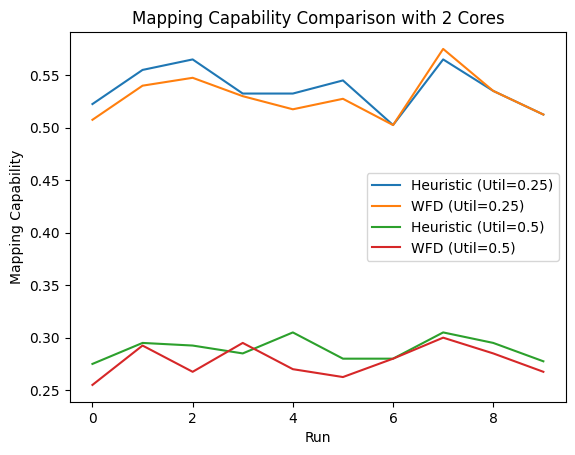

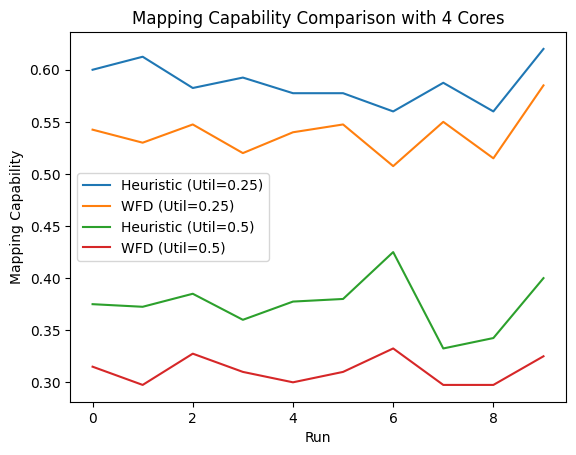

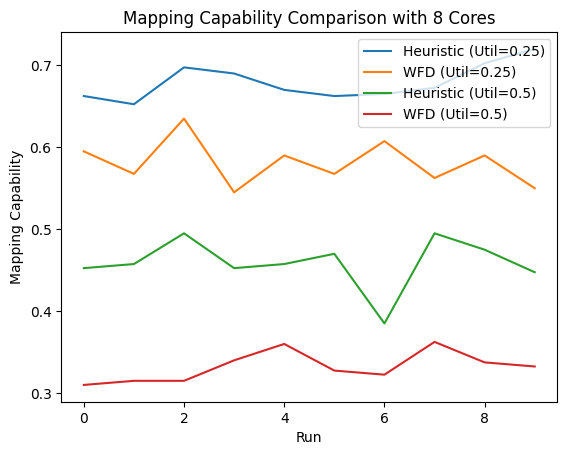

In [127]:
num_tasks = 400
total_utils = [0.25, 0.5]
criticality_levels = ['LC', 'HC']
num_cores_list = [2, 4, 8]
num_runs = 10

# Evaluate mapping capability
resources = generate_resources(low_bound=2, high_bound=6)
mapping_results = {}

for num_cores in num_cores_list:
    mapping_results[num_cores] = evaluate_mapping_capability(
        num_tasks=num_tasks,
        total_utils=total_utils,
        criticality_levels=criticality_levels,
        num_cores=num_cores,
        resources=resources,
        num_runs=num_runs
    )

# Plot mapping capability results
for num_cores, results in mapping_results.items():
    plt.figure()
    for util, data in results.items():
        heuristic_mapping_rates = [d[0] for d in data]
        wfd_mapping_rates = [d[1] for d in data]
        plt.plot(heuristic_mapping_rates, label=f'Heuristic (Util={util})')
        plt.plot(wfd_mapping_rates, label=f'WFD (Util={util})')
    plt.xlabel('Run')
    plt.ylabel('Mapping Capability')
    plt.title(f'Mapping Capability Comparison with {num_cores} Cores')
    plt.legend()
    plt.show()

### **Part 4: Implementing EDF-VD scheduling under MSRP Protocol**

In [17]:
def schedule_tasks(cores, resources, is_overrun):
    """
    Schedules tasks on cores for the specified duration using EDF-VD under MSRP protocol.

    Args:
        cores (list of Core): List of cores.
        resources (list of Resource): List of resources.
        is_overrun (bool): is overrun will occur or not
    """
    for core in cores:
        core.calculate_resource_ceiling(resources=resources)

    tasks_periods = [task.period for core in cores for task in core.tasks]
    tasks_periods = [int(period) for period in tasks_periods]
    duration = hyper_period = np.lcm.reduce(tasks_periods)

    switch_mode_point = None
    if is_overrun:
        switch_mode_point = round(random.choice([hyper_period / 4, hyper_period / 3, hyper_period / 2]), 2)

    step = 0.01
    for time in tqdm(np.arange(0, duration, step), desc="time progress"):

        # Handle overrun
        if time == switch_mode_point:
            for resource in resources:
                if resource.task:
                    if resource.task.criticality == 'LC':
                        resource.release()
            cores = set_preemption_levels(cores=cores, is_overrun=True)
            for core in cores:
                core.calculate_resource_ceiling(resources=resources)

        for core in cores:
            for task in core.tasks:
                if round(time % task.period, 2) == 0:
                    if task.remaining_time > 0:
                        is_missed = True
                        return is_missed
                    else:
                        task.remaining_time = task.exec_time_lc

        # check for release all resources at the time
        for core in cores:
            resource = core.check_for_release()
            if resource:
                resource.release()
                if core.is_on_busy_waiting:
                    core.is_on_busy_waiting = False

            task = core.next_task(resources=resources)
            is_ok = core.schedule_task(task=task, time=time, step=step)
            if not is_ok:
                is_missed = True
                return is_missed

    return False

### **Part 5: Evaluating Schedulability**

### Schedulability Evaluation Function
This function evaluates the schedulability of the the schedule_tasks function in both overrun and normal runs.

In [4]:
def evaluate_schedulability(num_tasks, util, criticality_levels, num_cores, resources, num_runs):
    """
    Evaluates the schedulability of the scheduler.

    Args:
        num_tasks (int): Number of tasks.
        util (float): utilization to be tested.
        criticality_levels (list of str): List of criticality levels.
        num_cores (int): Number of cores.
        resources (list of Resource): List of resources in the system.
        num_runs (int): Number of runs for each configuration.

    Returns:
        dict: Results of schedulability for both overrun and normal mode runs.
    """
    results = {"overrun doesn't occurred": [], "overrun occurred": []}
    is_overrun = False
    

    for i in range(2):
        if i == 1:
            is_overrun = True
        for _ in range(num_runs):
            tasks = generate_tasks(
                low_bound=1.00,
                high_bound=5.00,
                num_tasks=num_tasks,
                total_util=util * num_cores,
                max_util=util,
                criticality_levels=criticality_levels,
                resources=resources,
                resource_usage_rate=0.25,
                scaling_factor=1
            )

            cores = generate_cores(num_cores=num_cores, resources=resources)
            # Set virtual deadlines
            tasks = set_virtual_deadlines(tasks)
            # Heuristic mapping algorithm    
            heuristic_mapping_rate = heuristic_mapping(tasks=tasks, cores=cores)
            # Set preemption levels
            cores = set_preemption_levels(cores=cores)
            # run scheduling algorithm
            is_missed = schedule_tasks(cores=cores, resources=resources, is_overrun=is_overrun)
            if is_overrun:
                results["overrun occurred"].append(is_missed)
            else:
                results["overrun doesn't occurred"].append(is_missed)
    return results

### **Part 6: Running Evaluations and Plotting Results**

Evaluations for schedulability is performed for each number of cores and run modes.

time progress:   0%|          | 0/1200 [00:00<?, ?it/s]


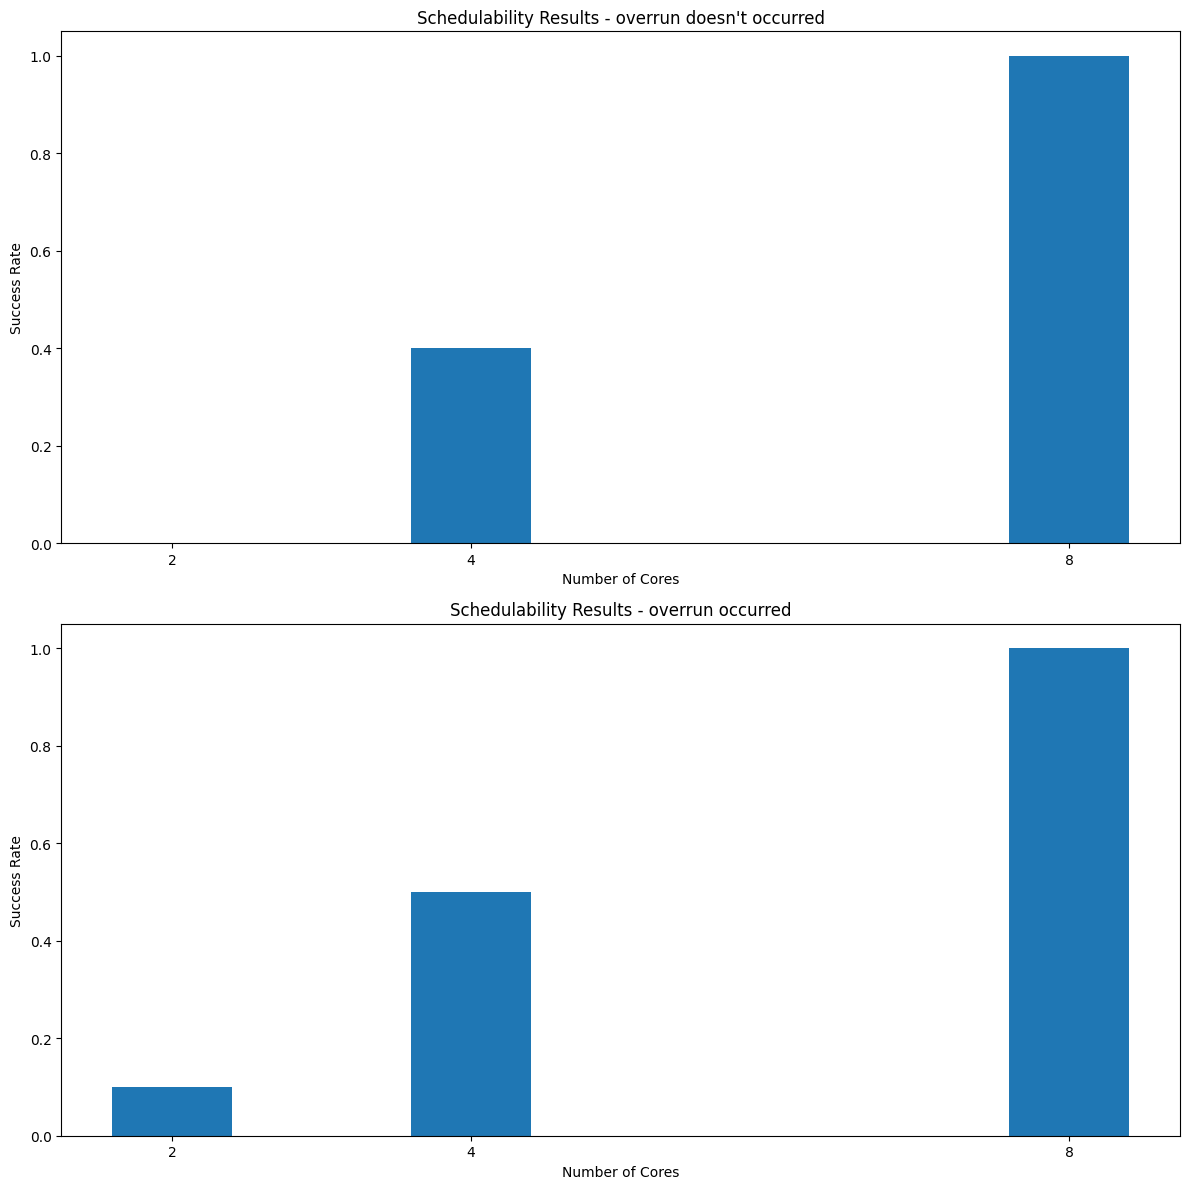

In [60]:
num_tasks = 100
util = 0.25
criticality_levels = ['LC', 'HC']
num_cores_list = [2, 4, 8]
num_runs = 10

resources = generate_resources(low_bound=2, high_bound=6)

schedulability_results = {"overrun doesn't occurred": {}, "overrun occurred": {}}

for state in ["overrun doesn't occurred", "overrun occurred"]:
    for num_cores in num_cores_list:
        schedulability_results[state][num_cores] = evaluate_schedulability(
            num_tasks=num_tasks,
            util=util,
            criticality_levels=criticality_levels,
            num_cores=num_cores,
            resources=resources,
            num_runs=num_runs
        )[state]

# Plot schedulability results
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

for idx, (state, results) in enumerate(schedulability_results.items()):
    x = num_cores_list
    y = [sum(results[cores]) / len(results[cores]) for cores in num_cores_list]
    axs[idx].bar(x, y)
    axs[idx].set_title(f'Schedulability Results - {state}')
    axs[idx].set_xlabel('Number of Cores')
    axs[idx].set_ylabel('Success Rate')
    axs[idx].set_xticks(num_cores_list)

plt.tight_layout()
plt.show()

### **Part 7: Conclusion**

**In this project, in the first phase, task mapping algorithms in a two-level mixed-criticality system were implemented and evaluated. The evaluation results were presented as mapping capability charts, showing the performance of the proposed algorithm compared to the WFD algorithm. The result was amazing.**
- ***The more cores, higher capability!***
- ***The higher the core utilization, the lower the capacity***
- ***Our heuristic mapping works better than wfd in the number of cores, by a greater margin, because the measure of resource congestion on the core is more meaningful, and naturally, as the effectiveness of this term increases, our heuristic mapping will be better than wfd.***

**At the second phase, task scheduling was tested by many different parameters and finally the results were interesting.**
- ***The more core, higher schedulability!*** 
- ***In overrun mode, tasks are often scheduled without missing their deadlinesو but in normal mode, the probability of missing the deadline is higher.***